# Support Vector Machine

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.05G/1.06G [00:09<00:00, 233MB/s]
100% 1.06G/1.06G [00:09<00:00, 123MB/s]


In [4]:
import zipfile
zip_ref=zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

**Importing Libraries**

In [49]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,Dropout

In [6]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [7]:
def process(image,label):
  image= tf.cast(image/255. ,tf.float32)
  return image,label

  train_ds = train_ds.map(process)
  validation_ds = validation_ds.map(process)

**Building CNN Model**

In [8]:


model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 76s 106ms/step - loss: 1.4279 - accuracy: 0.5939 - val_loss: 0.5897 - val_accuracy: 0.6860
Epoch 2/10
625/625 [==============================] - 65s 104ms/step - loss: 0.5457 - accuracy: 0.7260 - val_loss: 0.5286 - val_accuracy: 0.7190
Epoch 3/10
625/625 [==============================] - 67s 107ms/step - loss: 0.4747 - accuracy: 0.7721 - val_loss: 0.4778 - val_accuracy: 0.7868
Epoch 4/10
625/625 [==============================] - 71s 113ms/step - loss: 0.4137 - accuracy: 0.8127 - val_loss: 0.4457 - val_accuracy: 0.7898
Epoch 5/10
625/625 [==============================] - 67s 105ms/step - loss: 0.3504 - accuracy: 0.8492 - val_loss: 0.4675 - val_accuracy: 0.7930
Epoch 6/10
625/625 [==============================] - 63s 101ms/step - loss: 0.2798 - accuracy: 0.8837 - val_loss: 0.4825 - val_accuracy: 0.7962
Epoch 7/10
625/625 [==============================] - 65s 103ms/step - loss: 0.2050 - accuracy: 0.9179 - val_loss: 0.5585 - val_ac

In [48]:
model.save('dogs_vs_cats.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Build SVM**

In [25]:

svm_model = svm.SVC(kernel='linear', C=1)

In [29]:
# Define a new Keras model that outputs the features from the CNN model
feature_extractor = keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Define a function to extract features from the CNN model
def extract_features(dataset):
    features = []
    labels = []
    for images, labels_batch in dataset:
        features_batch = feature_extractor(images)
        features.extend(features_batch.numpy())
        labels.extend(labels_batch.numpy())
    return np.array(features), np.array(labels)

# Extract features from the training and validation datasets
train_features, train_labels = extract_features(train_ds)
validation_features, validation_labels = extract_features(validation_ds)

**Feature Scaling**

In [30]:

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
validation_features_scaled = scaler.transform(validation_features)


**  Train the SVM model**

In [31]:

svm_model = svm.SVC(kernel='linear', C=1)
svm_model.fit(train_features_scaled, train_labels)

SVC(C=1, kernel='linear')

**Evaluate the SVM model**

In [33]:

svm_accuracy = svm_model.score(validation_features_scaled, validation_labels)
print(f"SVM Accuracy: {svm_accuracy:.3f}")

SVM Accuracy: 0.792


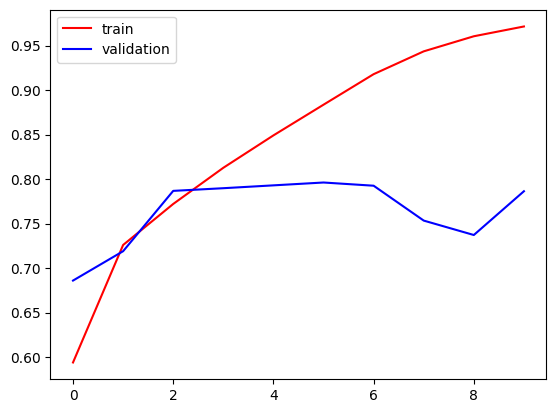

In [41]:


plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

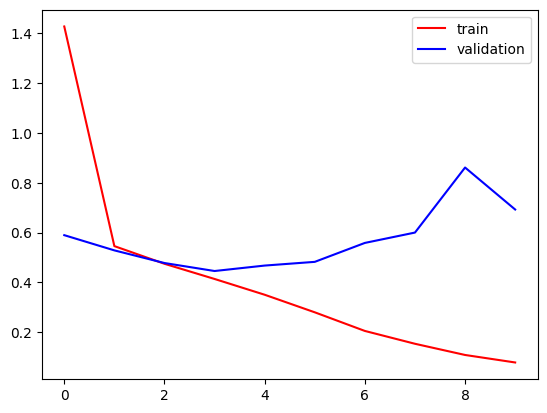

In [40]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

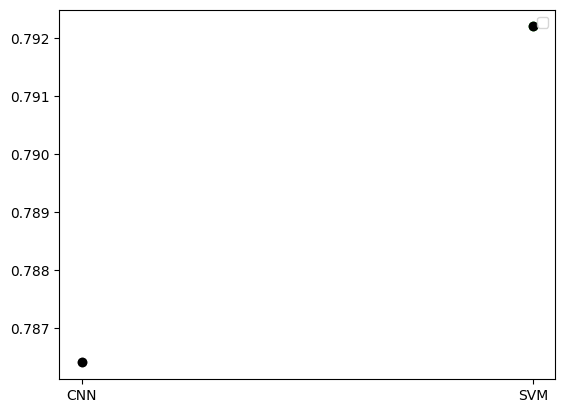

In [44]:
# Plot the SVM accuracy and CNN accuracy
plt.plot(['CNN', 'SVM'], [history.history['val_accuracy'][-1], svm_accuracy], marker='o', linestyle='None', color='black')
plt.scatter(['CNN'], [history.history['val_accuracy'][-1]], color='gray')
plt.scatter(['SVM'], [svm_accuracy], color='green')
plt.legend()
plt.show()